# Multilayer Perceptron trained with PyTorch

Implement a multilayer perceptron model for the classification of the 10 classes from the [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset.

A multilayer perceptron (MLP) for Fashion MNIST classification is a basic neural network with input, hidden, and output layers used to categorize images of clothing into one of ten categories. The MLP would learn from the pixel data of each image to identify patterns and features that represent different types of clothing items. Using PyTorch, a leading deep learning framework, makes building and training such a model accessible due to its powerful libraries and GPU acceleration.

## Importing the necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
from typing import Tuple, List

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.1  Device: cuda


## Preparing the dataset: Dataset type class

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        The constructor for the MNISTDataset class.

        Loads data from a CSV file, processing it for use in a machine learning model.
        Each row in the CSV file represents an MNIST image, where the first column is the label, and the rest
        of the columns represent the image pixels.

        :param path_csv: The path to the CSV file containing MNIST data.
        :type path_csv: str
        """
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'The path {path_csv} does not point to a file'

        # Loading the data, excluding the header if it exists
        _all_digits: np.ndarray = pd.read_csv(path_csv, header=0, dtype=float).values

        _y: np.ndarray = _all_digits[:, 0]  # the labels
        _x: np.ndarray = _all_digits[:, 1:] / 255  # input values scaled to 0..1

        self.x: torch.Tensor = torch.Tensor(_x)  # conversion to PyTorch tensors
        self.y: torch.Tensor = torch.Tensor(_y)

    def __len__(self) -> int:
        """
        Returns the number of examples in the dataset.

        :return: The length of the dataset.
        :rtype: int
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a data example and associated label, indexed by the 'index' parameter.

        :param index: The index of the desired example.
        :type index: int
        :return: A tuple (data, label), where 'data' is a pixel tensor, and 'label' is a tensor with the label.
        :rtype: Tuple[torch.Tensor, torch.Tensor]
        """
        return self.x[index, :], self.y[index]

# Creating Dataset instances
train_ds = MNISTDataset('./data/fashion-mnist_train.csv')
test_ds = MNISTDataset('./data/fashion-mnist_test.csv')

In [3]:
batch_size: int = 32
train_loader: DataLoader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(test_ds, batch_size=batch_size)

## Model Definition

In [4]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size: int = 784, hidden_sizes: list = [128, 64], num_classes: int = 10):
        """
        Initializes a MultilayerPerceptron object.

        :param input_size: The size of an input vector, for example, for MNIST it's 784.
        :type input_size: int
        :param hidden_sizes: A list containing the number of neurons in each hidden layer.
        :type hidden_sizes: list[int]
        :param num_classes: The number of classes for output classification.
        :type num_classes: int
        """
        super(MultilayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        
        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Add the intermediate hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Add the output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagates the inputs (x) through the model.

        :param x: A minibatch of examples of shape [batch_size, input_size].
        :type x: torch.Tensor
        :return: Class scores before softmax application, of shape [batch_size, num_classes].
        :rtype: torch.Tensor
        """
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Using the class for a multilayer perceptron
model = MultilayerPerceptron()

In [5]:
print(model)

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [6]:
summary(model);

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       100,480
|    └─Linear: 2-2                       8,256
|    └─Linear: 2-3                       650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0


In [7]:
print(f'device={device}')
model.to(device)

device=cuda


MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss()

In [9]:
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs: int = 30
train_accuracies: List[float] = []
test_accuracies: List[float] = []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss: float = 0.0
    train_correct: int = 0
    train_total: int = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy: float = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Test
    model.eval()
    test_correct: int = 0
    test_total: int = 0
    y_pred: List[int] = []
    y_true: List[int] = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.view(-1).tolist())
            y_true.extend(labels.view(-1).tolist())

    test_accuracy: float = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')


Epoch 1, Loss: 0.5368979120691617, Train Accuracy: 80.755%, Test Accuracy: 85.5%
Epoch 2, Loss: 0.3856822210510572, Train Accuracy: 86.03666666666666%, Test Accuracy: 86.89%
Epoch 3, Loss: 0.3461348499755065, Train Accuracy: 87.35%, Test Accuracy: 87.56%
Epoch 4, Loss: 0.3246784425179164, Train Accuracy: 88.08166666666666%, Test Accuracy: 87.91%
Epoch 5, Loss: 0.307242127319177, Train Accuracy: 88.685%, Test Accuracy: 87.24%
Epoch 6, Loss: 0.2917849307477474, Train Accuracy: 89.12833333333333%, Test Accuracy: 87.16%
Epoch 7, Loss: 0.27738049835364026, Train Accuracy: 89.59666666666666%, Test Accuracy: 88.65%
Epoch 8, Loss: 0.2669544986138741, Train Accuracy: 90.10166666666667%, Test Accuracy: 88.48%
Epoch 9, Loss: 0.25636663749019306, Train Accuracy: 90.465%, Test Accuracy: 88.48%
Epoch 10, Loss: 0.2480028448899587, Train Accuracy: 90.68833333333333%, Test Accuracy: 89.25%
Epoch 11, Loss: 0.23791575162708758, Train Accuracy: 90.97166666666666%, Test Accuracy: 88.62%
Epoch 12, Loss: 0.2

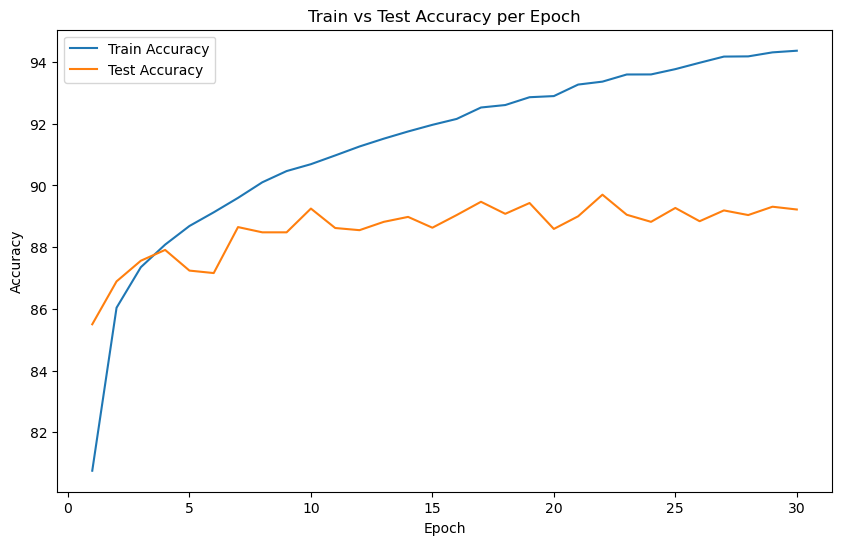

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy per Epoch')
plt.legend()
plt.show()

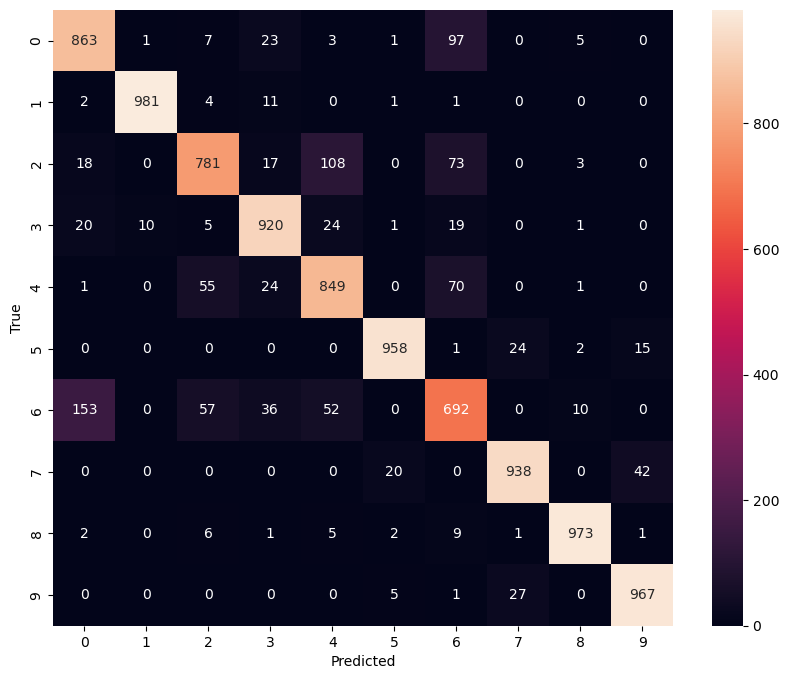

In [12]:
conf_matrix: np.ndarray = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Displaying the Loss Graph on the Training Set

In [13]:
losses: List[float] = []

for epoch in range(num_epochs):
    model.train()
    running_loss: float = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss: float = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')


Epoch 1, Loss: 0.14316418007463216
Epoch 2, Loss: 0.14135063246016702
Epoch 3, Loss: 0.13867099253709117
Epoch 4, Loss: 0.13463353825062513
Epoch 5, Loss: 0.13237316028630983
Epoch 6, Loss: 0.13292342290083567
Epoch 7, Loss: 0.1300588191992293
Epoch 8, Loss: 0.12646217722113554
Epoch 9, Loss: 0.12289437686850627
Epoch 10, Loss: 0.12177049410231411
Epoch 11, Loss: 0.11957657060051957
Epoch 12, Loss: 0.1156491771598036
Epoch 13, Loss: 0.11468851698438326
Epoch 14, Loss: 0.11208710663542151
Epoch 15, Loss: 0.11047637584762027
Epoch 16, Loss: 0.10965325911585241
Epoch 17, Loss: 0.10503206732695301
Epoch 18, Loss: 0.10600813300460576
Epoch 19, Loss: 0.10358881172301869
Epoch 20, Loss: 0.10222806336687257
Epoch 21, Loss: 0.10208524041933317
Epoch 22, Loss: 0.09817434858943647
Epoch 23, Loss: 0.09906664068698882
Epoch 24, Loss: 0.09630090178319564
Epoch 25, Loss: 0.09232853500434818
Epoch 26, Loss: 0.09405938250146186
Epoch 27, Loss: 0.08961436491771602
Epoch 28, Loss: 0.089902998999611
Epoch

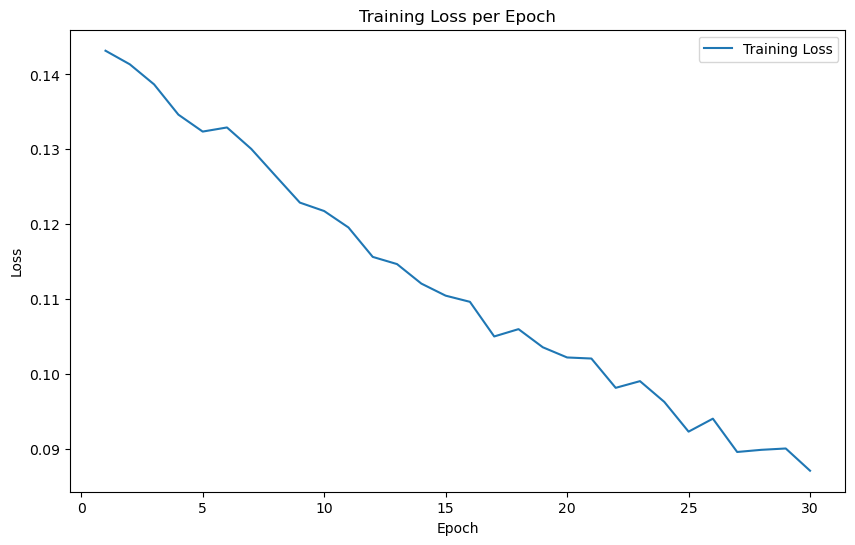

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## Implementation of the Momentum Method in Updating Weights

In [15]:
optimizer: torch.optim.Optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
from typing import List

losses: List[float] = []

for epoch in range(num_epochs):
    model.train()
    running_loss: float = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss: float = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')


Epoch 1, Loss: 0.051680081230433036
Epoch 2, Loss: 0.04471406598954151
Epoch 3, Loss: 0.04255403039059602
Epoch 4, Loss: 0.04132162336326825
Epoch 5, Loss: 0.040176808130570375
Epoch 6, Loss: 0.039453038086004866
Epoch 7, Loss: 0.0385979623580919
Epoch 8, Loss: 0.037847283884642334
Epoch 9, Loss: 0.037369634291339514
Epoch 10, Loss: 0.036788915090550045
Epoch 11, Loss: 0.03635260374017137
Epoch 12, Loss: 0.03576625200896136
Epoch 13, Loss: 0.035420342186062284
Epoch 14, Loss: 0.03486664324797069
Epoch 15, Loss: 0.034468636027452884
Epoch 16, Loss: 0.0341018881883511
Epoch 17, Loss: 0.03372681006325874
Epoch 18, Loss: 0.03338982168257547
Epoch 19, Loss: 0.03294008814142241
Epoch 20, Loss: 0.03265195296246093
Epoch 21, Loss: 0.03227665462230798
Epoch 22, Loss: 0.031845698803779666
Epoch 23, Loss: 0.031533655155694576
Epoch 24, Loss: 0.031225608222415515
Epoch 25, Loss: 0.030918342527328058
Epoch 26, Loss: 0.030607907738443463
Epoch 27, Loss: 0.030340625155666687
Epoch 28, Loss: 0.0301064

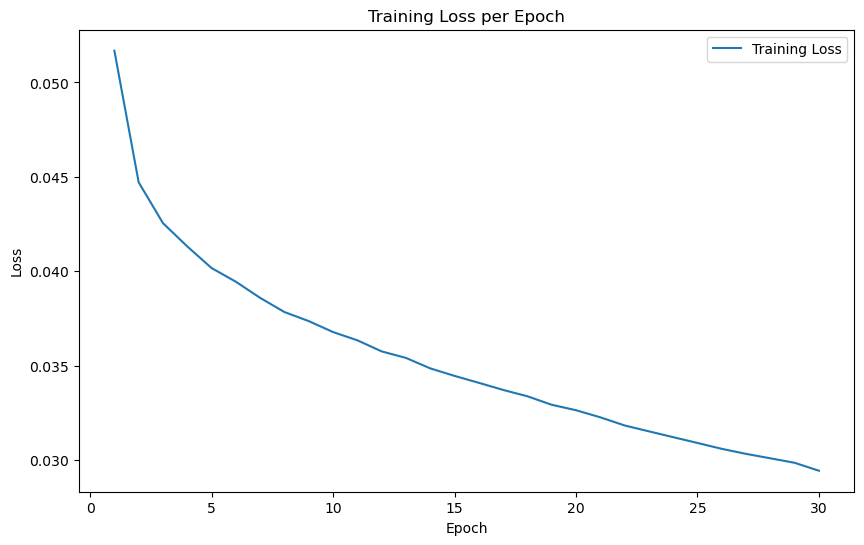

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## Confusion Matrix with Percentages and Heatmap

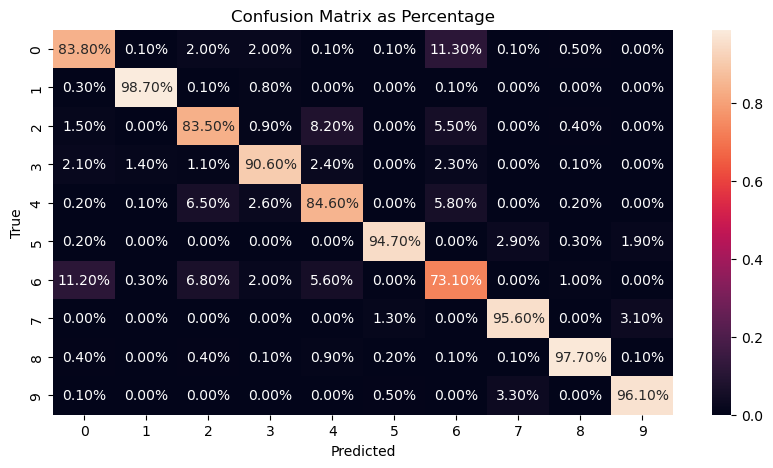

In [18]:
y_pred: List[int] = []
y_true: List[int] = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf_matrix: np.ndarray = confusion_matrix(y_true, y_pred)
conf_matrix_normalized: np.ndarray = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  # Convertirea în procente

plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix as Percentage')
plt.show()
